In [1]:
"""
Sample script to compute spatially averaged monthly statistics
based on pre-saved monthly sums.

"""

import sys;       sys.path.append('../../shared/python/')
import warnings;  warnings.filterwarnings("ignore")
import os

import numpy             as np
import matplotlib.pyplot as plt

from datetime               import datetime, timedelta
from dateutil.relativedelta import relativedelta
from netCDF4                import Dataset, num2date

In [2]:
def get_mean_stats_from_sums(fnc4_sums):

    var_list = ['obs_obs', 'obs_fcst','obs_ana']

    mdata_sum = {}
    mdata2_sum = {}
    with Dataset(fnc4_sums,'r') as nc:
        mN_data = nc.variables['N_data'][:]
        moxf_sum = nc.variables['obsxfcst_sum'][:]
        moxa_sum = nc.variables['obsxana_sum'][:]
        moxf_sum[mN_data == 0] = np.nan
        moxa_sum[mN_data == 0] = np.nan
        for var in var_list:
            mdata_sum[var] = nc.variables[var+'_sum'][:]
            mdata2_sum[var] = nc.variables[var+'2_sum'][:]
            mdata_sum[var][mN_data == 0] = np.nan
            mdata2_sum[var][mN_data == 0] = np.nan

    # Make sure only aggregate tiles with valid values for all variables
    for var in var_list:
        mN_data = mN_data.astype(float)
        mN_data[np.isnan(mdata_sum[var])] = np.nan
        mN_data[mN_data == 0] = np.nan

    # cross mask before aggregating tile values   
    for var in var_list:
        mdata_sum[var][np.isnan(mN_data)] = np.nan
        mdata2_sum[var][np.isnan(mN_data)] = np.nan
        moxf_sum[np.isnan(mN_data)] = np.nan
        moxa_sum[np.isnan(mN_data)] = np.nan

    # Aggregate data of all tiles
    N_data = np.nansum(mN_data,axis=0)
    OxF_mean = np.nansum(moxf_sum,axis=0)/N_data
    OxA_mean = np.nansum(moxa_sum,axis=0)/N_data
    data_mean = {}
    data2_mean = {}
    data_var = {}
    for var in var_list:
        data_mean[var] = np.nansum(mdata_sum[var],axis=0)/N_data
        data2_mean[var] = np.nansum(mdata2_sum[var],axis=0)/N_data
        # var(x) = E[x2] - (E[x])^2
        data_var[var] = data2_mean[var] - data_mean[var]**2

    # Computer metrics of O-F, O-A, etc. based on above stats
    O_mean = data_mean['obs_obs']
    F_mean = data_mean['obs_fcst']
    A_mean = data_mean['obs_ana']
    O_var = data_var['obs_obs']
    F_var = data_var['obs_fcst']
    A_var = data_var['obs_ana']

    # mean(x-y) = E[x] - E[y]   
    OmF_mean = O_mean - F_mean
    OmA_mean = O_mean - A_mean

    # var(x-y) = var(x) + var(y) - 2cov(x,y)
    # cov(x,y) = E[xy] - E[x]E[y]
    OmF_stdv  = np.sqrt(O_var + F_var - 2 * (OxF_mean - O_mean*F_mean))
    OmA_stdv  = np.sqrt(O_var + A_var - 2 * (OxA_mean - O_mean*A_mean))

    # Combine metrics of individual species using weighted averaging
    # Nobs_data = np.nansum(N_data)
    # OmF_mean = np.nansum(OmF_mean*N_data)/Nobs_data
    # OmF_stdv = np.nansum(OmF_stdv*N_data)/Nobs_data
    # OmA_mean = np.nansum(OmA_mean*N_data)/Nobs_data
    # OmA_stdv = np.nansum(OmA_stdv*N_data)/Nobs_data

    return O_mean, F_mean, OmF_mean, OmF_stdv, OmA_mean, OmA_stdv, N_data

In [7]:
import calendar
import pickle

# Define time range for processing
start_time = datetime(2002,10,1)
end_time = datetime(2006,10,1)

# expid = 'DAv8_M36_Aus'
# exptag = 'DA'
# mo_sums_path = '/discover/nobackup/projects/land_da/CYGNSS_Experiments/DAv8_M36_Aus_v3/DAv8_M36_Aus/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg/'

exp_main = { 'expdir' : '/discover/nobackup/projects/land_da/snow_qc_expts/1e_LS_DAv8_M36_0/',
                    'expid' : '1e_LS_OLv8_M36_0',
                    'exptag': 'OL_DA_Obs_from_DA', 
                    'domain':  'SMAP_EASEv2_M36_GLOBAL',
                    'da_t0' : 3,       # first hour of the month 
                    'da_dt' : 10800}   # ObsFcstAna file interval in second

exp_list = [exp_main]

# User provided monthly sum files directory
mo_sums_path = exp_list[0]['expdir']+exp_list[0]['expid']+ \
              '/output/'+exp_list[0]['domain']+'/ana/ens_avg/'

# User provided output directory 
out_path = exp_list[0]['expdir']+exp_list[0]['expid']+ \
              '/output/'+exp_list[0]['domain']+'/figures/'
os.makedirs(out_path, exist_ok=True)


date_time = start_time
O_mean   =[]
F_mean   =[]
OmF_mean =[]
OmF_stdv =[]
OmA_mean =[]
OmA_stdv =[]
Ndata    =[]
date_vec =[]

while date_time < end_time:
    print('compute monthly spatial mean stats for '+date_time.strftime('%Y%m'))
    fname_sums = mo_sums_path+'/Y'+date_time.strftime('%Y')+ \
        '/M'+date_time.strftime('%m')+'/'+exp_list[0]['exptag']+ \
        '.ens_avg.ldas_ObsFcstAna.'+date_time.strftime('%Y%m')+'_sums.nc4'

    if os.path.isfile(fname_sums):
        Om,Fm,OmFm,OmFs,OmAm,OmAs,Nobsm = get_mean_stats_from_sums(fname_sums)
    else:
        print(f"ERROR: File '{fname_sums}' not found.")
        sys.exit(1)
    
    O_mean.append(Om)
    F_mean.append(Fm)
    OmF_mean.append(OmFm)
    OmF_stdv.append(OmFs)
    OmA_mean.append(OmAm)
    OmA_stdv.append(OmAs)
    Ndata.append(Nobsm)

    date_vec.append(date_time.strftime('%Y%m'))
    date_time = date_time + relativedelta(months=1)


compute monthly spatial mean stats for 200210
compute monthly spatial mean stats for 200211
compute monthly spatial mean stats for 200212
compute monthly spatial mean stats for 200301
compute monthly spatial mean stats for 200302
compute monthly spatial mean stats for 200303
compute monthly spatial mean stats for 200304
compute monthly spatial mean stats for 200305
compute monthly spatial mean stats for 200306
compute monthly spatial mean stats for 200307
compute monthly spatial mean stats for 200308
compute monthly spatial mean stats for 200309
compute monthly spatial mean stats for 200310
compute monthly spatial mean stats for 200311
compute monthly spatial mean stats for 200312
compute monthly spatial mean stats for 200401
compute monthly spatial mean stats for 200402
compute monthly spatial mean stats for 200403
compute monthly spatial mean stats for 200404
compute monthly spatial mean stats for 200405
compute monthly spatial mean stats for 200406
compute monthly spatial mean stats

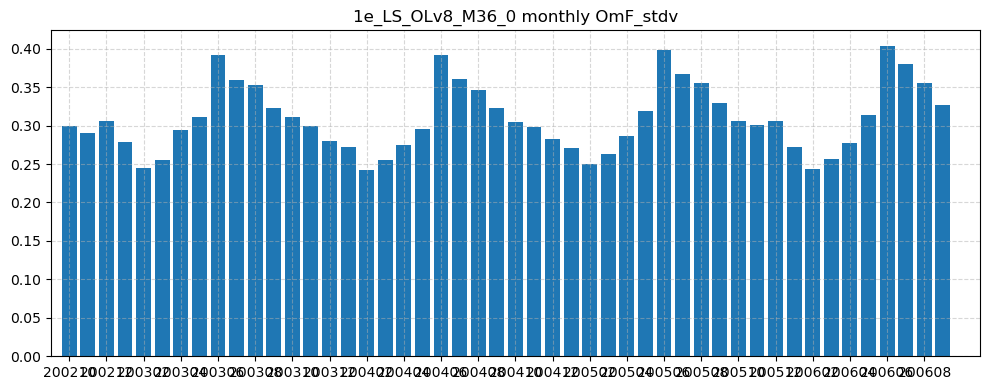

In [8]:

stats_dict = {"O_mean":O_mean,
              "F_mean":F_mean,
              "OmF_mean":OmF_mean,
              "OmF_stdv":OmF_stdv,
              "OmA_mean":OmA_mean,
              "OmA_stdv":OmA_stdv,
              "Ndata": Ndata}

# Define plot variable and title
var_name = "OmF_stdv"  # Use string instead of array
plot_data = np.array([month[0] for month in stats_dict[var_name]])

# Create plot
fig, ax = plt.subplots(figsize=(10,4))
bars = ax.bar(date_vec, plot_data)

# Add grid and customize axes
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(ticks=date_vec[::2], labels=date_vec[::2])
plt.title(f"{exp_list[0]['expid']} monthly {var_name}")
plt.xlim(-1, len(date_vec)+1)
# plt.ylim(-.7, 1.5)
plt.tight_layout()

# Save and display
output_filename = f"Bars_{var_name}_{exp_list[0]['expid']}_{start_time.strftime('%Y%m')}_{end_time.strftime('%Y%m')}.png"
plt.savefig(output_filename)
plt.show()
plt.close()

In [9]:
print("OmF_stdv.shape = ",np.shape(OmF_stdv))

# Create dictionary with both objects
save_dict = {
    'stats_dict': stats_dict,
    'date_vec': date_vec
}

# Format dates
start_date = start_time.strftime("%Y%m")
end_date = end_time.strftime("%Y%m")
exp_id = exp_list[0]['expid']

# Construct filename
stats_filename = f'stats_{exp_id}_{start_date}_{end_date}.pkl'

# Create full path
save_path = os.path.join(out_path, stats_filename)

# Save dictionary
with open(save_path, 'wb') as f:
    pickle.dump(save_dict, f)

print(f"Saved data to {save_path}")

# To load later:
# with open(save_path, 'rb') as f:
#     loaded_data = pickle.load(f)
# stats_dict = loaded_data['stats_dict']
# date_vec = loaded_data['date_vec']


OmF_stdv.shape =  (48, 2)
Saved data to /discover/nobackup/projects/land_da/snow_qc_expts/1e_LS_DAv8_M36_0/1e_LS_OLv8_M36_0/output/SMAP_EASEv2_M36_GLOBAL/figures/stats_1e_LS_OLv8_M36_0_200210_200610.pkl
